In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import anndata
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

/home/michal/miniconda3/envs/sad2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class EncoderNN(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(EncoderNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, latent_dim)
        self.linear3 = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))

        return mu, sigma

In [3]:
class EncoderGaussian(nn.Module):
    def __init__(self, encoder):
        super(EncoderGaussian, self).__init__()
        self.encoder = encoder
    
    def sample(mu, std):
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
        return z
    
    def log_prob(mu, std, z):
        return torch.distributions.Normal(mu, std).log_prob(z)
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        std = torch.exp(log_var / 2)
        z = EncoderGaussian.sample(mu, std)
        return z, mu, std

In [4]:
class DecoderNN(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim):
        super(DecoderNN, self).__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z):
        out = F.relu(self.linear1(z))
        out = torch.sigmoid(self.linear2(out))
        return out

In [5]:
class DecoderGaussian(nn.Module):
    def __init__(self, decoder):
        super(DecoderGaussian, self).__init__()
        self.decoder = decoder
        self.log_variance = nn.Parameter(torch.Tensor([0.0]))
    
    def log_prob_xz(self, mean, log_variance, x):
        x = torch.flatten(x, start_dim=1)
        variance = torch.exp(log_variance)
        dist = torch.distributions.Normal(mean, variance)
        # measure prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum(dim=(1))
    
    def forward(self, z, x):
        out = self.decoder(z)
        recon_loss = self.log_prob_xz(out, self.log_variance, x)
        return out, recon_loss

In [6]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, encoder, decoder, beta):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = EncoderGaussian(encoder)
        self.decoder = DecoderGaussian(decoder)
        self.beta = beta

    def kl_divergence(self, z, mu, std):
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)
        Dkl = (log_qzx - log_pz).sum(-1)
        return Dkl

    def sample(self, mean, log_variance):
        variance = torch.exp(log_variance)
        dist = torch.distributions.Normal(mean, variance)
        x_hat = dist.sample()
        return x_hat
    
    def forward(self, x):
        z, mu, std = self.encoder(x)
        decoder_out, recon_loss = self.decoder(z, x)
        Dkl = self.kl_divergence(z, mu, std)
        elbo = (Dkl * self.beta - recon_loss).mean()
        x_hat = self.sample(decoder_out, self.decoder.log_variance)
        return decoder_out, self.decoder.log_variance, elbo, Dkl.mean(), recon_loss.mean(), x_hat, z

In [7]:
def train(VAE, dataloader, optimizer, device='cpu'):
    device = torch.device(device)
    VAE = VAE.to(device)
    train_elbo = 0
    train_Dkl = 0
    train_recon_loss = 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)
        _, _, elbo, Dkl, recon_loss, _, _ = VAE(X)
        # Backpropagation
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        train_elbo += elbo
        train_Dkl += Dkl
        train_recon_loss += recon_loss
        
        if batch % 100 == 0:
            elbo, current = elbo.item(), batch * len(X)
            print(f"elbo: {elbo:>7f}  [{current:>5d}/{size:>5d}]")
    
    return train_elbo/num_batches, train_Dkl/num_batches, train_recon_loss/num_batches


In [8]:
def test(VAE, dataloader, device='cpu'):
    device = torch.device(device)
    VAE = VAE.to(device)
    num_batches = len(dataloader)
    test_elbo = 0
    test_Dkl = 0
    test_recon_loss = 0
    z_full = None


    with torch.no_grad():
        for batch, (X, cell_type) in enumerate(dataloader):
            X = X.to(device)
            _, _, elbo, Dkl, recon_loss, _, z = VAE(X)
            z = z.detach().numpy()
            z = np.c_[z, cell_type]
            if batch == 0:
              z_full = z
            else:
              z_full = np.concatenate((z_full, z), axis=0)
            test_elbo += elbo
            test_Dkl += Dkl
            test_recon_loss += recon_loss
        
    
    return test_elbo/num_batches, test_Dkl/num_batches, test_recon_loss/num_batches, z_full

In [9]:
class scRNADataset(Dataset):
    def __init__(self, h5ad_file: str, sample: float, transform=None):
        self.data = sc.read_h5ad(h5ad_file)
        self.cell_type = np.array(self.data.obs.cell_type)
        self.data = self.data.layers['counts'].toarray()
        l_cells = round(len(self.data) * sample)
        self.data = self.data[:l_cells]
        #self.data = preprocessing.normalize(self.data)
        self.data = self.data/np.max(self.data)

        # minval = self.data.min()
        # maxval = self.data.max()
        # self.data = (self.data - minval)/(maxval-minval)
        # self.data = self.data + 1e-9
        # self.data = np.log(self.data)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        single_cell = self.data[idx]
        single_cell_type = self.cell_type[idx]

        if self.transform:
            single_cell = self.transform(single_cell)

        return single_cell, single_cell_type

In [10]:
def create_dataloader_dict(h5ad_file_train: str, h5ad_file_test: str, batch_size: int, shuffle: bool, sample: float, transform=None):
  training_data = scRNADataset(h5ad_file_train, sample=sample, transform=transform)
  test_data = scRNADataset(h5ad_file_test, sample=sample, transform=transform)

  train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=shuffle, num_workers=1, pin_memory=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=shuffle, num_workers=1, pin_memory=True)

  return {'train': train_dataloader,
          'val': test_dataloader}

In [11]:
sample = 0.1
beta = 1
lr = 1e-2
ldim = 100
hdim1 = 250

dataloader_dict = create_dataloader_dict('data/SAD2022Z_Project1_GEX_train.h5ad',
                                         'data/SAD2022Z_Project1_GEX_test.h5ad',
                                         batch_size=64, shuffle=False, sample=sample, transform=torch.from_numpy)

train_dataloader = dataloader_dict['train']
test_dataloader = dataloader_dict['val']

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

encoder_nn = EncoderNN(5000, ldim, hidden_dim=hdim1)
decoder_nn = DecoderNN(5000, ldim, hidden_dim=hdim1)
vae = VariationalAutoencoder(encoder_nn, decoder_nn, beta=beta)
optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
epochs = 8

train_elbo_list = []
train_Dkl_list = []
train_recon_loss_list = []
test_elbo_list = []
test_Dkl_list = []
test_recon_loss_list = []


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    elbo_train, Dkl_train, recon_loss_train, = train(vae, train_dataloader, optimizer)
    train_elbo_list.append(elbo_train)
    train_Dkl_list.append(Dkl_train)
    train_recon_loss_list.append(recon_loss_train)
    
    elbo_test, Dkl_test, recon_loss_test, z = test(vae, test_dataloader)

    test_elbo_list.append(elbo_test)
    test_Dkl_list.append(Dkl_test)
    test_recon_loss_list.append(recon_loss_test)


print("Done!")

Using cuda device
Epoch 1
-------------------------------


RuntimeError: mat1 and mat2 must have the same dtype

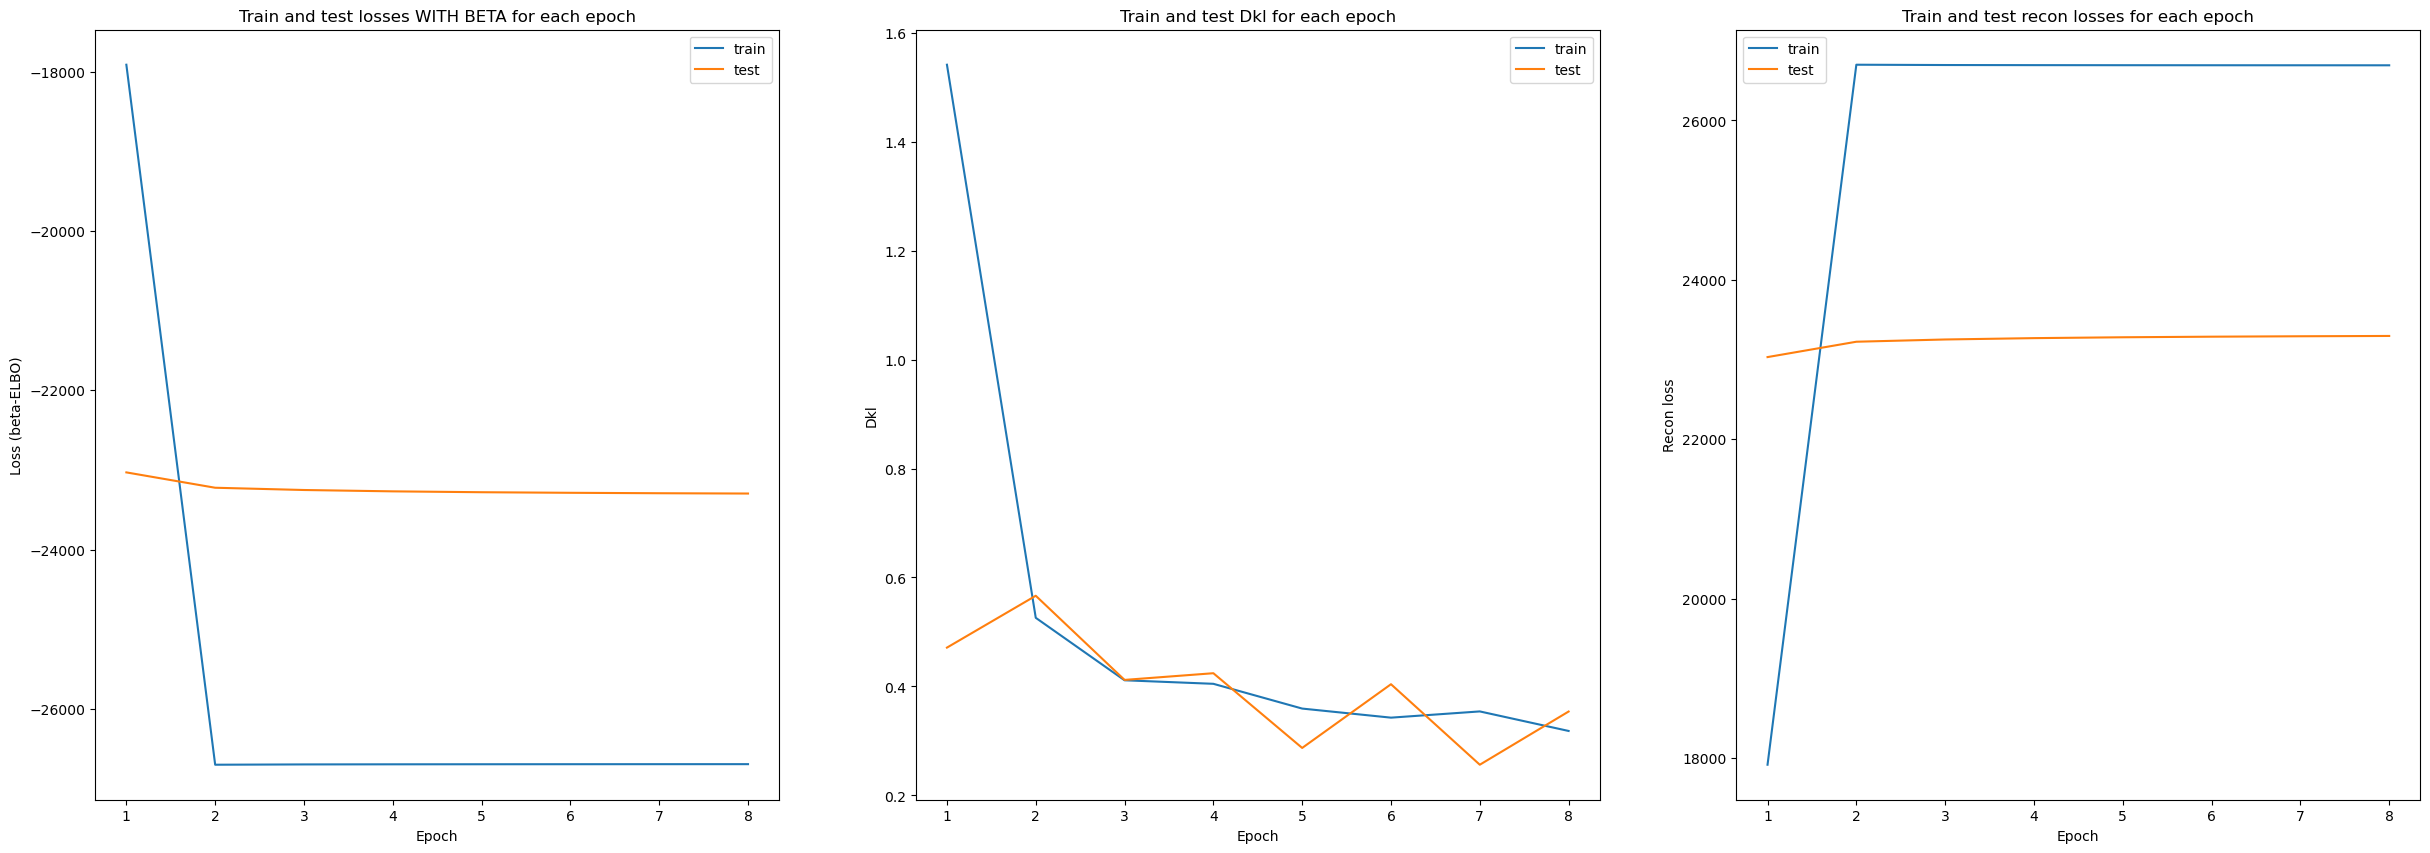

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))

epochs_list = [t+1 for t in range(epochs)]
test_elbo_list_np = [float(obs.detach().numpy()) for obs in test_elbo_list]
train_elbo_list_np = [float(obs.detach().numpy()) for obs in train_elbo_list]

train_Dkl_list_np = [float(obs.detach().numpy()) for obs in train_Dkl_list]
test_Dkl_list_np = [float(obs.detach().numpy()) for obs in test_Dkl_list]

train_recon_loss_list_np = [float(obs.detach().numpy()) for obs in train_recon_loss_list]
test_recon_loss_list_np = [float(obs.detach().numpy()) for obs in test_recon_loss_list]


axes[0].plot(epochs_list, train_elbo_list_np, label='train')
axes[0].plot(epochs_list, test_elbo_list_np, label='test')
axes[0].set_title('Train and test losses WITH BETA for each epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (beta-ELBO)')
axes[0].legend()

axes[1].plot(epochs_list, train_Dkl_list_np, label='train')
axes[1].plot(epochs_list, test_Dkl_list_np, label='test')
axes[1].set_title('Train and test Dkl for each epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dkl')
axes[1].legend()

axes[2].plot(epochs_list, train_recon_loss_list_np, label='train')
axes[2].plot(epochs_list, test_recon_loss_list_np, label='test')
axes[2].set_title('Train and test recon losses for each epoch')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Recon loss')
axes[2].legend()

plt.show()

In [ ]:
import sklearn
import matplotlib.colors as mcolors


In [ ]:
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
px = pd.DataFrame(z)
pca = decomposition.PCA()
px_std_reg = StandardScaler().fit_transform(px.iloc[:,0:ldim])
pca_res = pca.fit_transform(px_std_reg)
pca_res = pd.DataFrame(pca_res, columns=[f'S{i}' for i in range(1,len(pca_res[0])+1)])
pca_res['cell_type'] = px.iloc[:,ldim]
exp_var_pca = pca.explained_variance_ratio_

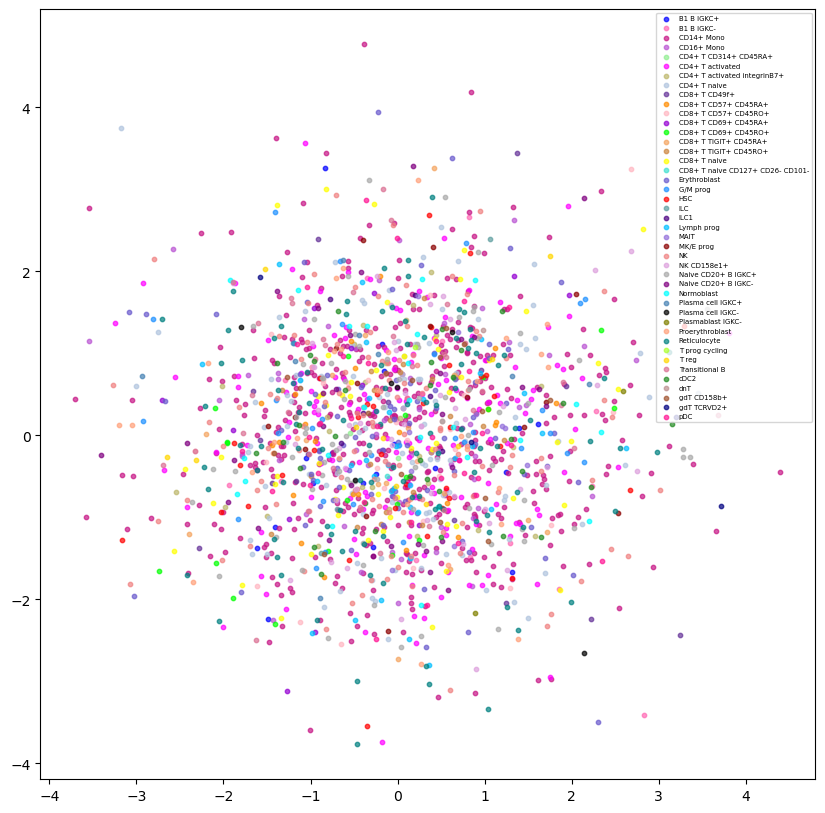

In [ ]:
cell_types = set(pca_res['cell_type'])
colors = ['black', 'darkgray', 'rosybrown', 'lightcoral', 'darkred', 'red', 'lightsalmon',
'sienna', 'sandybrown', 'peru', 'darkorange', 'gold', 'darkkhaki', 'olive',
'yellow', 'forestgreen', 'greenyellow', 'lightgreen', 'lime', 'turquoise', 'teal', 'aqua',
'cadetblue', 'deepskyblue', 'steelblue', 'dodgerblue', 'lightsteelblue',
'navy', 'blue', 'slateblue', 'mediumpurple', 'rebeccapurple',
'indigo', 'darkviolet', 'mediumorchid', 'plum' , 'purple', 'fuchsia',
'mediumvioletred', 'deeppink', 'hotpink', 'palevioletred', 'lightpink']

pca_res_2 = pca_res.iloc[:,:]

group = pca_res_2['cell_type']
color_dict = {key: color for key, color in zip(cell_types, colors)}

fig, ax = plt.subplots(figsize=(10,10))

for g in np.unique(group):
    ix = np.where(group == g)[0].tolist()
    ax.scatter(pca_res_2['S1'][ix],  pca_res_2['S2'][ix], c = color_dict[g], label = g, s = 10, alpha=0.7)
ax.legend(fontsize=5)
plt.show()

In [ ]:
#len(z)=30
var = 0
i = 0
for e in exp_var_pca:
  i += 1
  if var>0.95:
    break
  var += e

print(f'95% jest wyjaśniane przez {i}/{len(exp_var_pca)} skłaowych głównych')

95% jest wyjaśniane przez 94/100 skłaowych głównych
